In [2]:
import os
import pandas as pd
import mysql.connector
import pickle
from flask import Flask, render_template, request, jsonify
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go

In [9]:
filename = open('model.pkl', 'rb')
model = pickle.load(filename)

In [23]:
test = {
  "campaignName": "test",
  "description": "test",
  "monetaryGoal": "100000",
  "duration": 35,
  "categories":142,
  "country": 3,
  "user_id": 15
}

data = test

# Change json to dataframe
data.update((x, [y]) for x, y in data.items())
data_df = pd.DataFrame.from_dict(data)
data_df

,campaignName,description,monetaryGoal,duration,categories,country,user_id
0,test,test,100000,35,142,3,15


In [10]:
df = pd.read_csv('df_small.csv')
df

,id,campaignName,description,categories,duration,monetaryGoal,country,city,state,date_created,deadline_date,launched_date,state_changed_at,backers_count,usd_pledged,url,target
0,1123889576,mars-on-earth-an-art-residency,Help a fine art photographer continue her proj...,Space Exploration,27,1000,US,Boston,MA,2015-06-24,2015-10-23,2015-09-26,2015-10-23,53,1884,https://www.kickstarter.com/projects/cassandra...,successful
1,1724173143,vulcan-i-rocket-powered-by-3d-printed-engine,Team of undergraduates racing to be the first ...,Space Exploration,30,15000,US,San Diego,CA,2014-05-06,2015-05-21,2015-04-21,2015-05-21,465,21882,https://www.kickstarter.com/projects/105499101...,successful
2,707260502,starscraper-the-next-generation-of-suborbital-...,What if we built a rocket that is better than ...,Space Exploration,31,10000,US,Boston,MA,2014-11-29,2015-01-09,2014-12-09,2015-01-09,294,17176,https://www.kickstarter.com/projects/burpg/sta...,successful
3,497637964,students-building-a-near-space-balloon-with-li...,A group of high school students are building a...,Space Exploration,30,150,US,Mountain View,CA,2014-11-19,2015-11-26,2015-10-27,2015-11-26,45,970,https://www.kickstarter.com/projects/136362214...,successful
4,1546008758,earth-360,Re-inventing the way we look at our planet by ...,Space Exploration,30,7500,US,Fairfield,CT,2012-04-11,2012-09-21,2012-08-22,2012-09-21,28,7576,https://www.kickstarter.com/projects/211370922...,successful
5,344236683,kansas-city-ssep-mission-5-rocket-321-blast-off,Middle-schoolers designed a microgravity exper...,Space Exploration,29,10500,US,Kansas City,MO,2014-03-24,2014-04-30,2014-04-01,2014-04-30,100,10710,https://www.kickstarter.com/projects/kcssepmis...,successful
6,1837559447,action-man-gi-joe-mission-mercury-10,Mission to launch a vintage Action Man and Spa...,Space Exploration,37,2842,GB,Coalville,England,2016-02-08,2016-04-30,2016-03-24,2016-04-30,72,4825,https://www.kickstarter.com/projects/actionman...,successful
7,281256757,asteroid-what-very-near-earth-asteroids,Free and easy to use information when asteroid...,Space Exploration,27,1456,AU,Sydney,NSW,2016-04-27,2016-06-30,2016-06-03,2016-06-30,81,2300,https://www.kickstarter.com/projects/559654604...,successful
8,1920229724,james-webb-deployable-model,Production of variously-sized deployable model...,Space Exploration,30,25000,US,Durango,CO,2015-07-08,2015-08-25,2015-07-26,2015-08-25,238,28633,https://www.kickstarter.com/projects/202718351...,successful
9,283133908,equatorial-sundial-learn-about-planetary-motion,A simple way to learn and teach complex astron...,Space Exploration,30,500,US,Lincoln,CA,2014-09-07,2014-10-20,2014-09-20,2014-10-20,159,4388,https://www.kickstarter.com/projects/805298412...,successful


In [14]:
df['categories'].replace(categories, inplace=True)
df.head()

,id,campaignName,description,categories,duration,monetaryGoal,country,city,state,date_created,deadline_date,launched_date,state_changed_at,backers_count,usd_pledged,url,target
0,1123889576,mars-on-earth-an-art-residency,Help a fine art photographer continue her proj...,0,27,1000,US,Boston,MA,2015-06-24,2015-10-23,2015-09-26,2015-10-23,53,1884,https://www.kickstarter.com/projects/cassandra...,successful
1,1724173143,vulcan-i-rocket-powered-by-3d-printed-engine,Team of undergraduates racing to be the first ...,0,30,15000,US,San Diego,CA,2014-05-06,2015-05-21,2015-04-21,2015-05-21,465,21882,https://www.kickstarter.com/projects/105499101...,successful
2,707260502,starscraper-the-next-generation-of-suborbital-...,What if we built a rocket that is better than ...,0,31,10000,US,Boston,MA,2014-11-29,2015-01-09,2014-12-09,2015-01-09,294,17176,https://www.kickstarter.com/projects/burpg/sta...,successful
3,497637964,students-building-a-near-space-balloon-with-li...,A group of high school students are building a...,0,30,150,US,Mountain View,CA,2014-11-19,2015-11-26,2015-10-27,2015-11-26,45,970,https://www.kickstarter.com/projects/136362214...,successful
4,1546008758,earth-360,Re-inventing the way we look at our planet by ...,0,30,7500,US,Fairfield,CT,2012-04-11,2012-09-21,2012-08-22,2012-09-21,28,7576,https://www.kickstarter.com/projects/211370922...,successful


In [17]:
df['country'].replace(countries, inplace=True)

In [18]:
df.categories.nunique()
df['monetaryGoal'].dtype

dtype('int64')

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

pipeline = make_pipeline(
    RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)
)

# pick features
target = 'target'
features = ['categories', 'duration'
            , 'monetaryGoal', 'country']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

pipeline.fit(X_train, y_train)

In [27]:
data_df['monetaryGoal'] = (data_df['monetaryGoal'][0])
data_df['monetaryGoal'].astype('int64')
data_df['monetaryGoal']

0    100000
Name: monetaryGoal, dtype: object

In [24]:
# If user input contains anything the model doesn't
drop_columns = ['campaignName', 'description', 'user_id']
data_df.drop(columns = drop_columns, inplace=True)

model_result = model.predict(data_df)
model_result

array([0], dtype=int64)

In [29]:
test = {
  "campaignName": "test",
  "description": "test",
  "monetaryGoal": "100000",
  "duration": 35,
  "categories":142,
  "country": 3,
  "user_id": 15
}

data = test

# Change json to dataframe
data.update((x, [y]) for x, y in data.items())
data_df = pd.DataFrame.from_dict(data)

drop_columns = ['campaignName', 'description', 'user_id']
data_df.drop(columns = drop_columns, inplace=True)

positive_class = 'successful'
positive_class_index = 1 

# Call model for prediction
pred = model.predict(data_df)
predict = pred[0]

# Get predicted probability
pred_proba = model.predict_proba(data_df)[0,positive_class_index]

probability = pred_proba * 100
# if pred != positive_class:
#     probability = 100 - probability

probability = round(probability)

# Return prediction and probability
output1 = f'State is {probability:.0f}% likely to be successful'

print(pred)
print(predict)
print(pred_proba)

output1

[0]
0
0.3


'State is 30% likely to be successful'

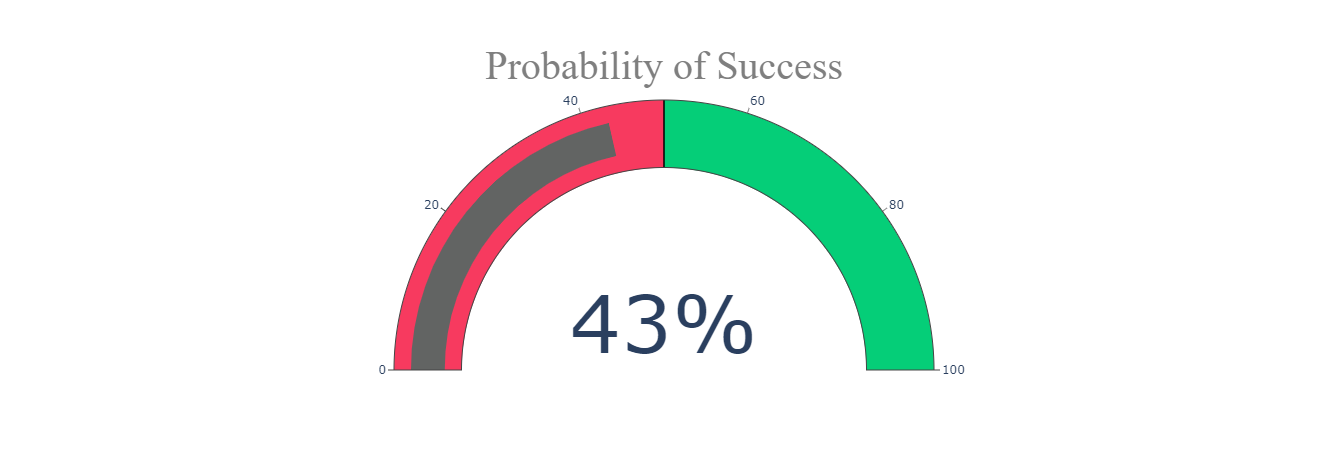

In [87]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number", 
    value = probability,
    number = {'suffix': "%"},
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "Probability of Success", 'font':{'family':'Droid Sans Mono', 'size':40, 'color':'#7f7f7f'}},
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "#626463"},
             'steps' : [
                 {'range': [0, 50], 'color': "#f73a5f"}, 
                 {'range': [50, 100], 'color': "#05ce78"}], 
             'threshold' : {'line': {'color': "black", 'width': 1}, 'thickness': 1, 'value': 50}}))

fig.show()


In [9]:
category = data_df['categories'].map(flipped)[0]
category

'Software'

In [5]:
flipped = {0: 'Space Exploration',
 1: 'Wearables',
 2: 'Hardware',
 3: 'Software',
 4: 'Web',
 5: 'Sound',
 6: "Children's Books",
 7: 'Calendars',
 8: 'Art Books',
 9: 'Fiction',
 10: 'Nature',
 11: 'People',
 12: 'Letterpress',
 13: 'Literary Journals',
 14: 'Nonfiction',
 15: 'Footwear',
 16: 'Jewelry',
 17: 'Pet Fashion',
 18: 'Ready-to-wear',
 19: 'Apparel',
 20: 'Animation',
 21: 'Comedy',
 22: 'Documentary',
 23: 'Action',
 24: 'Textiles',
 25: 'Sculpture',
 26: 'Public Art',
 27: 'Performance Art',
 28: 'Crafts',
 29: 'DIY',
 30: 'Woodworking',
 31: 'Knitting',
 32: 'Candles',
 33: 'Quilts',
 34: 'Glass',
 35: 'Embroidery',
 36: 'Crochet',
 37: 'Pottery',
 38: 'Product Design',
 39: 'Graphic Design',
 40: 'Design',
 41: 'Typography',
 42: 'Interactive Design',
 43: 'Civic Design',
 44: 'Architecture',
 45: 'Shorts',
 46: 'Narrative Film',
 47: 'Film & Video',
 48: 'Webseries',
 49: 'Thrillers',
 50: 'Family',
 51: 'Experimental',
 52: 'Science Fiction',
 53: 'Fantasy',
 54: 'Music Videos',
 55: 'Horror',
 56: 'Movie Theaters',
 57: 'Drama',
 58: 'Romance',
 59: 'Television',
 60: 'Festivals',
 61: 'Food',
 62: 'Small Batch',
 63: "Farmer's Markets",
 64: 'Restaurants',
 65: 'Farms',
 66: 'Drinks',
 67: 'Events',
 68: 'Food Trucks',
 69: 'Cookbooks',
 70: 'Vegan',
 71: 'Spaces',
 72: 'Community Gardens',
 73: 'Bacon',
 74: 'Fashion',
 75: 'Accessories',
 76: 'Couture',
 77: 'Childrenswear',
 78: 'Places',
 79: 'Digital Art',
 80: 'Flight',
 81: 'Graphic Novels',
 82: 'Dance',
 83: 'R&B',
 84: 'Performances',
 85: 'Gaming Hardware',
 86: 'Mobile Games',
 87: 'Gadgets',
 88: 'Young Adult',
 89: 'Illustration',
 90: 'Translations',
 91: 'Zines',
 92: 'Weaving',
 93: 'Ceramics',
 94: 'Radio & Podcasts',
 95: 'Immersive',
 96: 'Technology',
 97: 'Blues',
 98: 'DIY Electronics',
 99: 'Jazz',
 100: 'Electronic Music',
 101: 'Apps',
 102: 'Camera Equipment',
 103: 'Robots',
 104: '3D Printing',
 105: 'Workshops',
 106: 'Poetry',
 107: 'Photobooks',
 108: 'Photography',
 109: 'World Music',
 110: 'Mixed Media',
 111: 'Residencies',
 112: 'Fine Art',
 113: 'Classical Music',
 114: 'Printing',
 115: 'Webcomics',
 116: 'Animals',
 117: 'Publishing',
 118: 'Kids',
 119: 'Academic',
 120: 'Periodicals',
 121: 'Anthologies',
 122: 'Indie Rock',
 123: 'Comic Books',
 124: 'Games',
 125: 'Tabletop Games',
 126: 'Installations',
 127: 'Conceptual Art',
 128: 'Playing Cards',
 129: 'Puzzles',
 130: 'Metal',
 131: 'Video Games',
 132: 'Photo',
 133: 'Pop',
 134: 'Rock',
 135: 'Country & Folk',
 136: 'Print',
 137: 'Video',
 138: 'Latin',
 139: 'Faith',
 140: 'Art',
 141: 'Painting',
 142: 'Video Art',
 143: 'Makerspaces',
 144: 'Hip-Hop',
 145: 'Music',
 146: 'Stationery',
 147: 'Punk',
 148: 'Fabrication Tools',
 149: 'Chiptune',
 150: 'Musical',
 151: 'Theater',
 152: 'Comics',
 153: 'Plays',
 154: 'Journalism',
 155: 'Audio',
 156: 'Literary Spaces',
 157: 'Live Games',
 158: 'Taxidermy'}




In [13]:
categories = {'Space Exploration': 0,
 'Wearables': 1,
 'Hardware': 2,
 'Software': 3,
 'Web': 4,
 'Sound': 5,
 "Children's Books": 6,
 'Calendars': 7,
 'Art Books': 8,
 'Fiction': 9,
 'Nature': 10,
 'People': 11,
 'Letterpress': 12,
 'Literary Journals': 13,
 'Nonfiction': 14,
 'Footwear': 15,
 'Jewelry': 16,
 'Pet Fashion': 17,
 'Ready-to-wear': 18,
 'Apparel': 19,
 'Animation': 20,
 'Comedy': 21,
 'Documentary': 22,
 'Action': 23,
 'Textiles': 24,
 'Sculpture': 25,
 'Public Art': 26,
 'Performance Art': 27,
 'Crafts': 28,
 'DIY': 29,
 'Woodworking': 30,
 'Knitting': 31,
 'Candles': 32,
 'Quilts': 33,
 'Glass': 34,
 'Embroidery': 35,
 'Crochet': 36,
 'Pottery': 37,
 'Product Design': 38,
 'Graphic Design': 39,
 'Design': 40,
 'Typography': 41,
 'Interactive Design': 42,
 'Civic Design': 43,
 'Architecture': 44,
 'Shorts': 45,
 'Narrative Film': 46,
 'Film & Video': 47,
 'Webseries': 48,
 'Thrillers': 49,
 'Family': 50,
 'Experimental': 51,
 'Science Fiction': 52,
 'Fantasy': 53,
 'Music Videos': 54,
 'Horror': 55,
 'Movie Theaters': 56,
 'Drama': 57,
 'Romance': 58,
 'Television': 59,
 'Festivals': 60,
 'Food': 61,
 'Small Batch': 62,
 "Farmer's Markets": 63,
 'Restaurants': 64,
 'Farms': 65,
 'Drinks': 66,
 'Events': 67,
 'Food Trucks': 68,
 'Cookbooks': 69,
 'Vegan': 70,
 'Spaces': 71,
 'Community Gardens': 72,
 'Bacon': 73,
 'Fashion': 74,
 'Accessories': 75,
 'Couture': 76,
 'Childrenswear': 77,
 'Places': 78,
 'Digital Art': 79,
 'Flight': 80,
 'Graphic Novels': 81,
 'Dance': 82,
 'R&B': 83,
 'Performances': 84,
 'Gaming Hardware': 85,
 'Mobile Games': 86,
 'Gadgets': 87,
 'Young Adult': 88,
 'Illustration': 89,
 'Translations': 90,
 'Zines': 91,
 'Weaving': 92,
 'Ceramics': 93,
 'Radio & Podcasts': 94,
 'Immersive': 95,
 'Technology': 96,
 'Blues': 97,
 'DIY Electronics': 98,
 'Jazz': 99,
 'Electronic Music': 100,
 'Apps': 101,
 'Camera Equipment': 102,
 'Robots': 103,
 '3D Printing': 104,
 'Workshops': 105,
 'Poetry': 106,
 'Photobooks': 107,
 'Photography': 108,
 'World Music': 109,
 'Mixed Media': 110,
 'Residencies': 111,
 'Fine Art': 112,
 'Classical Music': 113,
 'Printing': 114,
 'Webcomics': 115,
 'Animals': 116,
 'Publishing': 117,
 'Kids': 118,
 'Academic': 119,
 'Periodicals': 120,
 'Anthologies': 121,
 'Indie Rock': 122,
 'Comic Books': 123,
 'Games': 124,
 'Tabletop Games': 125,
 'Installations': 126,
 'Conceptual Art': 127,
 'Playing Cards': 128,
 'Puzzles': 129,
 'Metal': 130,
 'Video Games': 131,
 'Photo': 132,
 'Pop': 133,
 'Rock': 134,
 'Country & Folk': 135,
 'Print': 136,
 'Video': 137,
 'Latin': 138,
 'Faith': 139,
 'Art': 140,
 'Painting': 141,
 'Video Art': 142,
 'Makerspaces': 143,
 'Hip-Hop': 144,
 'Music': 145,
 'Stationery': 146,
 'Punk': 147,
 'Fabrication Tools': 148,
 'Chiptune': 149,
 'Musical': 150,
 'Theater': 151,
 'Comics': 152,
 'Plays': 153,
 'Journalism': 154,
 'Audio': 155,
 'Literary Spaces': 156,
 'Live Games': 157,
 'Taxidermy': 158}

In [16]:
countries = {'US': 0,
 'GB': 1,
 'AU': 2,
 'ES': 3,
 'FR': 4,
 'CA': 5,
 'DE': 6,
 'IT': 7,
 'NL': 8,
 'CH': 9,
 'DK': 10,
 'NO': 11,
 'IE': 12,
 'SE': 13,
 'BE': 14,
 'AT': 15,
 'NZ': 16,
 'LU': 17,
 'SG': 18,
 'MX': 19,
 'HK': 20,
 'JP': 21}